In [1]:
from transformer_lens import HookedTransformer
import torch
import matplotlib.pyplot as plt
import os

torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained("meta-llama/Meta-Llama-3-8B", device="cuda")

/usr/local/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Meta-Llama-3-8B into HookedTransformer


In [2]:
A = """
(28, 59)
(86, 175)
(13, 29)
(37, 77)
(55, 113)
(84, 171)
(66, 135)
(85, 173)
(27, 57)
(15, 33)
(94, 191)
(37, 77)
(14, 31)
(42, 87)
(55, 113)
(60, 123)
"""

B = """
(60, 120)
(38, 76)
(96, 192)
(59, 118)
(53, 106)
(11, 22)
(87, 174)
(20, 40)
(11, 22)
(42, 84)
(70, 140)
(57, 114)
(83, 166)
(27, 54)
(90, 180)
(8, 16)
(72, 144)
(42, 84)
(15, 30)
(23, 46)
(25, 50)
(63, 126)
(49, 98)
(6, 12)
"""

baseline = """
(20, 71)
(40, 34)
(33, 10)
(63, 45)
(17, 63)
(5, 40)
(86, 56)
(45, 71)
(100, 57)
(16, 62)
(13, 98)
(42, 35)
(23, 65)
(35, 33)
(6, 70)
(25, 99)
(27, 40)
(81, 45)
(71, 19)
(49, 5)
(19, 86)
(56, 15)
(88, 16)
(37, 31)
(3, 54)
(33, 96)
"""

# we know that these states are about convergent, so I'm not too concerned about actual sequence length
# seems possible that this might be bad for publication but idgaf
# in an ideal world these should be equal

In [10]:
A_toks = model.to_tokens(A)
B_toks = model.to_tokens(B)

A_logits, A_activations = model.run_with_cache(A_toks, return_cache_object=False)

hook_point = "blocks.15.hook_resid_pre"

# since B = 2x
# A = 2x + 3
# we want to ablate B from A.

# our last few tokens (for both strings) are as follows:
# <space>, <last_integer>, )
# as a result we want to take the position -3

# A_vec = A_activations[hook_point].squeeze(0)[-4]
# B_vec = B_activations[hook_point].squeeze(0)[-4]

# # I want to try two things

# steering_ablated = A_vec - (torch.dot(A_vec, B_vec) * B_vec)
# steering_subtracted = A_vec - B_vec


# # I hope that these are somewhat similar? I'm going to use only the first one though
# # this is our task vector!

# print(torch.linalg.norm(steering_subtracted - steering_ablated))
# print(torch.linalg.norm(A_vec - B_vec))

# task_vector = steering_subtracted

A_vec_4 = A_activations[hook_point].squeeze(0)[-4]

A_vec_3 = A_activations[hook_point].squeeze(0)[-3]

def patching_hook(resid_post, hook):
    # resid_post[:, -4, :] = A_vec_4
    resid_post[:, -3, :] = A_vec_3

prediction = []
for i in range(1, 100): # this is our inference loop
    text = f"({i}, 59)\n" # again we just go in on our -3 index at the hook point
    tokens = model.to_tokens(text)

    patched_logits = model.run_with_hooks(
        tokens, fwd_hooks=[(hook_point, patching_hook)]
    )

    # now what we do is
    desired_logits = patched_logits.squeeze(0)[-3]
    topk = torch.topk(desired_logits, k=5)

    text = model.tokenizer.convert_ids_to_tokens(topk.indices)
    try:
        int_x = int(text[0])
        prediction.append(int_x)
    except:
        prediction.append(None)
        print(f"{text[0]} is not an integer")
    print(i, ",", text)

1 , ['2', '3', '1', '4', '5']
2 , ['4', '3', '5', '2', '6']
3 , ['6', '5', '4', '7', '3']
4 , ['8', '9', '7', '5', '6']
5 , ['10', '11', '9', '5', '7']
6 , ['12', '11', '7', '13', '10']
7 , ['14', '13', '15', '12', '7']
8 , ['16', '12', '15', '17', '10']
9 , ['18', '19', '17', '20', '10']
10 , ['20', '10', '15', '19', '21']
11 , ['22', '21', '23', '12', '11']
12 , ['24', '25', '23', '18', '12']
13 , ['26', '27', '25', '24', '28']
14 , ['28', '29', '30', '27', '26']
15 , ['30', '31', '15', '25', '29']
16 , ['32', '33', '34', '31', '30']
17 , ['34', '33', '35', '36', '32']
18 , ['36', '38', '37', '35', '30']
19 , ['39', '38', '37', '40', '36']
20 , ['40', '30', '39', '41', '20']
21 , ['42', '41', '43', '21', '40']
22 , ['44', '45', '42', '46', '43']
23 , ['47', '46', '48', '45', '49']
24 , ['48', '49', '50', '36', '47']
25 , ['50', '51', '25', '49', '45']
26 , ['52', '51', '50', '53', '54']
27 , ['54', '55', '53', '51', '56']
28 , ['56', '57', '58', '55', '54']
29 , ['59', '58', '57', '6

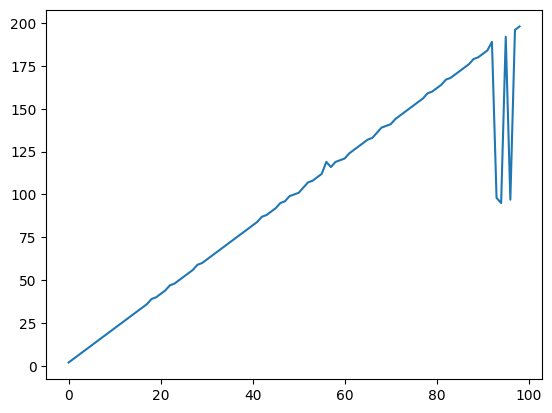

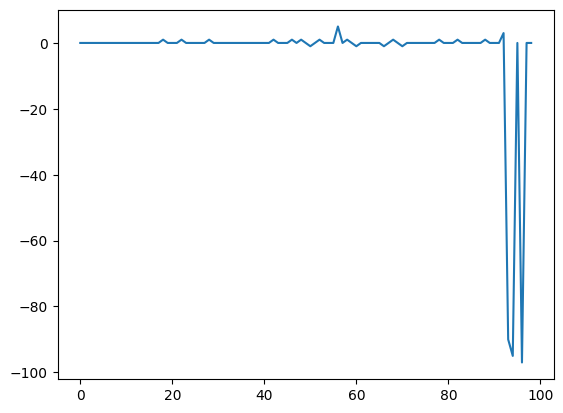

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, -1, 0, 1, 0, 0, 0, 5, 0, 1, 0, -1, 0, 0, 0, 0, 0, -1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, -90, -95, 0, -97, 0, 0]


In [11]:

pred = [p - 2 * idx - 2 for idx, p in enumerate(prediction)]

plt.plot(prediction)
plt.show()
plt.plot(pred)
plt.show()
print(pred)